In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

In [4]:
#import libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tqdm import tqdm
import pandas as pd

In [66]:
#data preprocessing
data_pd = pd.read_csv('training_set_pixel_size_and_HC.csv')
HC_pd = pd.DataFrame(data_pd['head circumference (mm)'])
HC_norm=HC_pd/HC_pd.max()
HC_norm

,head circumference (mm)
0,0.127887
1,0.164001
2,0.198470
3,0.199192
4,0.172662
...,...
994,0.950520
995,0.955254
996,0.957564
997,0.913626


In [8]:
!wget https://zenodo.org/record/1327317/files/training_set.zip?download=1

--2023-07-04 11:07:52--  https://zenodo.org/record/1327317/files/training_set.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132926838 (127M) [application/octet-stream]
Saving to: ‘training_set.zip?download=1’

training_set.zip?do 100%[===================>] 126.77M  4.76MB/s    in 41s     

2023-07-04 11:08:34 (3.10 MB/s) - ‘training_set.zip?download=1’ saved [132926838/132926838]



In [ ]:
!unzip /content/training_set.zip?download=1 -d /content

In [33]:

#data preprocessing
# Define paths to images directory
image_dir = '/content/training_set'

# Read images
image_data = []

for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        image_path = os.path.join(image_dir, filename)
        # Read image using OpenCV
        image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        # Append data to lists
        image_data.append(image)

# Convert lists to NumPy arrays
image_data = np.array(image_data)

# Verify the shapes of the image_data
print("Image Data Shape:", image_data.shape)

Image Data Shape: (1998,)


<ipython-input-33-0084270c31d3>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_data = np.array(image_data)


In [34]:
X = image_data[::2]
X_resize = np.zeros((999,224,224))
for i in range(999):
    X_resize[i] = cv2.resize(X[i],(224,224))

In [35]:
temp = []
for i in range(999):
    test_3 = np.zeros((224,224,3))
    test_3[:,:,0] = X_resize[i]
    test_3[:,:,1] = X_resize[i]
    test_3[:,:,2] = X_resize[i]
    temp.append(test_3)

X_3 = np.array(temp)

In [36]:
X_3.shape

(999, 224, 224, 3)

In [37]:
#split dataset into training and test sets 4:1
X_train, X_test, Y_train, Y_test = train_test_split(X_3,HC_norm, test_size=0.2, random_state=0,shuffle=True)

In [38]:
X_train.shape

(799, 224, 224, 3)

In [39]:
#Load the VGG16 Model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [40]:
#Step 3: Build the Regression Model
x = vgg16.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

model = Model(inputs=vgg16.input, outputs=predictions)

# Step 4: Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

In [84]:
# Step 5: Train and Evaluate the Model
model.fit(X_train,Y_train, validation_data=(X_test,Y_test), epochs=3, batch_size=8)
# results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=5)


Epoch 1/3
100/100 [==============================] - 1816s 18s/step - loss: 0.0425 - val_loss: 0.0268
Epoch 2/3
100/100 [==============================] - 1799s 18s/step - loss: 0.0405 - val_loss: 0.0258
Epoch 3/3
100/100 [==============================] - 1797s 18s/step - loss: 0.0411 - val_loss: 0.0313


In [85]:
# Step 6: Make Predictions
predictions = model.predict(X_test)

7/7 [==============================] - 133s 17s/step


In [2]:
HC_pred=pd.DataFrame(predictions)

In [82]:
Y_test['HC preds (mm)'] = HC_pred

In [83]:
Y_test

,head circumference (mm),HC preds (mm)
722,0.535797,0.403102
77,0.201386,0.275388
877,0.723441,0.420933
613,0.536114,0.465001
903,0.800837,0.582872
...,...,...
150,0.266628,0.619085
299,0.446016,0.493073
239,0.439954,0.603380
981,0.927540,0.675548


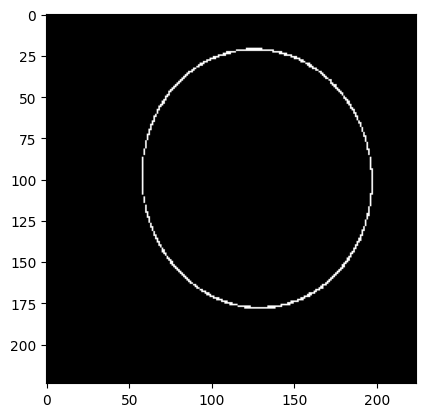

In [68]:
plt.imshow(X_test[1],cmap='gray')

In [69]:
Y_test.iloc[1]

head circumference (mm)    0.201386
pred                       0.275388
Name: 77, dtype: float64